# **Challenge: Hacking Your Energy Producers' Forecasting**


#### Given a sample of EV charging sessions, the objective is to model when and for how long the EVs in our portfolio charge from the grid.

Abel, Daniel, Katinka & Rebecca

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (12,5)
import seaborn as sns
sns.set()

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from random import random


In [282]:

df = pd.read_csv("charge_sessions_sampled.csv")
total_rows = len(df)
# df = df.sample(int(total_rows / 5))

# Convert timestamp
df['session_time'] = df['timestamp_end'] - df['timestamp_start']
df['timestamp_start'] = pd.to_datetime(df['timestamp_start'], unit='s')
df['timestamp_end'] = pd.to_datetime(df['timestamp_end'], unit='s')
df['week_day'] = df['timestamp_start'].dt.dayofweek 
df["session_time_hours"] = df["session_time"] / 3600
df = df.assign(Date=df.timestamp_start.dt.floor('H'))
df = df.assign(Day=df.timestamp_start.dt.floor('D'))
df["Hour"] = df.Date.dt.hour
# Exclude outliers
# df = df[np.abs(df.session_time-df.session_time.mean()) <= (3*df.session_time.std())]

# Exclude outliers
df = df[df['session_time_hours'] <  50]
df = df[df['session_time_hours'] > 0.01]
df = df[df["kwh_charged"] / df["session_time_hours"] < 50]
df = df[df['kwh_charged'] < 100] 
df = df[df['kwh_charged'] > 0] 
print(len(df))
df.head(5)




463302


,timestamp_start,timestamp_end,kwh_charged,session_time,week_day,session_time_hours,Date,Day,Hour
0,2019-05-13 22:58:49,2019-05-14 06:33:56,22.97,27307,0,7.585278,2019-05-13 22:00:00,2019-05-13,22
1,2019-05-20 11:21:22,2019-05-20 11:55:55,27.15,2073,0,0.575833,2019-05-20 11:00:00,2019-05-20,11
2,2019-05-07 16:42:32,2019-05-07 19:01:33,6.16,8341,1,2.316944,2019-05-07 16:00:00,2019-05-07,16
3,2019-05-04 13:33:54,2019-05-04 15:19:34,2.47,6340,5,1.761111,2019-05-04 13:00:00,2019-05-04,13
4,2019-05-12 11:10:29,2019-05-13 05:35:54,1.93,66325,6,18.423611,2019-05-12 11:00:00,2019-05-12,11


In [323]:
week_day_group = df.groupby("week_day").mean()
week_day_group["session_time"] = week_day_group["session_time"] / 3600

np.mean(week_day_group["session_time"])
week_day_group["normalize"] = week_day_group["session_time"] / np.mean(week_day_group["session_time"])
week_day_group.to_pickle("week_days.p")
week_day_group

,kwh_charged,session_time,session_time_hours,Hour,normalize
week_day,,,,,
0,16.440693,8.476401,8.476401,12.890613,0.983434
1,16.044607,8.413685,8.413685,12.884240,0.976158
2,16.050286,8.348038,8.348038,12.998730,0.968541
3,16.167307,8.323091,8.323091,13.024301,0.965647
4,15.962075,8.357234,8.357234,13.030159,0.969608
5,16.034737,9.294517,9.294517,13.661734,1.078352
6,17.153653,9.121330,9.121330,13.850248,1.058259


In [308]:
counted_df = df.groupby("Date").count()
mean_df = df.groupby("Date").mean()
y = counted_df['session_time']
y_mean = mean_df['session_time']
total_rows = len(y)
print(total_rows)

16859


## By counting number of cars that start charging, we can get an overview of the number of cars charging at a specific date and hour

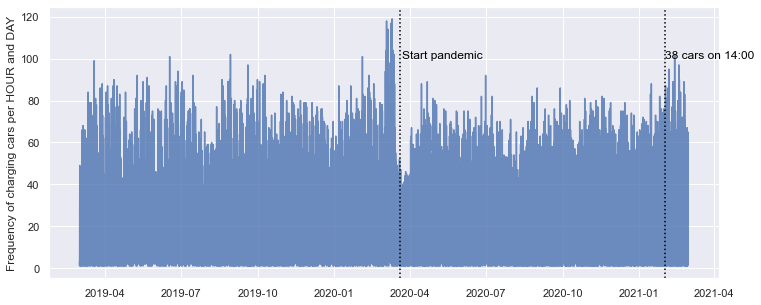

Number of charging cars on 2021-02-01 14:00: 38


In [292]:
plt.plot(counted_df.index, counted_df.session_time, alpha=0.8)
plt.axvline(x=pd.to_datetime("2020-03-20"), color="black", linestyle=":")
plt.text(x=pd.to_datetime("2020-03-22"), y=100, s="Start pandemic", color='black')
plt.ylabel("Frequency of charging cars per HOUR and DAY")

nr_cars = counted_df[counted_df.index == pd.to_datetime("2021-02-01 14:00")]['kwh_charged'][0]

plt.axvline(x=pd.to_datetime("2021-02-01 14:00"), color="black", linestyle=":")
plt.text(x=pd.to_datetime("2021-02-01 14:00"), y=100, s=str(nr_cars) + " cars on 14:00", color='black')
plt.show()
print('\033[1m'  + "Number of charging cars on 2021-02-01 14:00:", nr_cars)



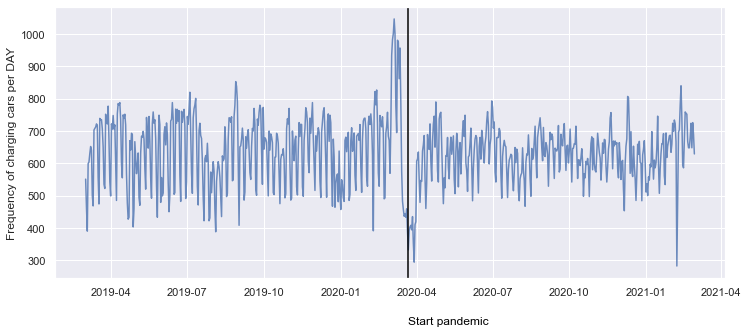

Total number of charging cars on start of pandemic in the Netherlands: 388


In [293]:
group_by_day = df.groupby("Day").count()

plt.plot(group_by_day.index, group_by_day.session_time, alpha=0.8)
plt.axvline(x=pd.to_datetime("2020-03-21"), color="black")
plt.ylabel("Frequency of charging cars per DAY")
plt.text(x=pd.to_datetime("2020-03-21"), y=100, s="Start pandemic", color='black')
plt.show()

nr_cars = group_by_day[group_by_day.index == pd.to_datetime("2020-03-21")]['kwh_charged'][0]
print('\033[1m'  + "Total number of charging cars on start of pandemic in the Netherlands:", nr_cars)

### Replace April values with previous year values

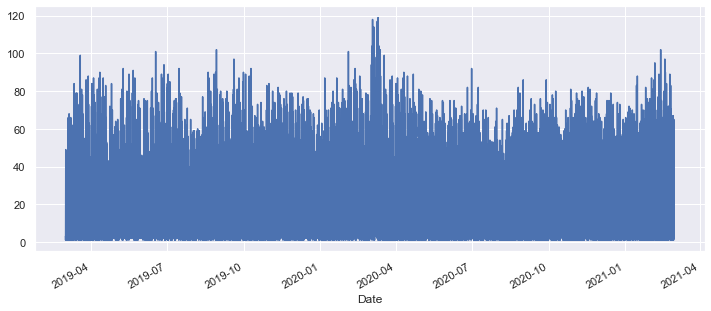

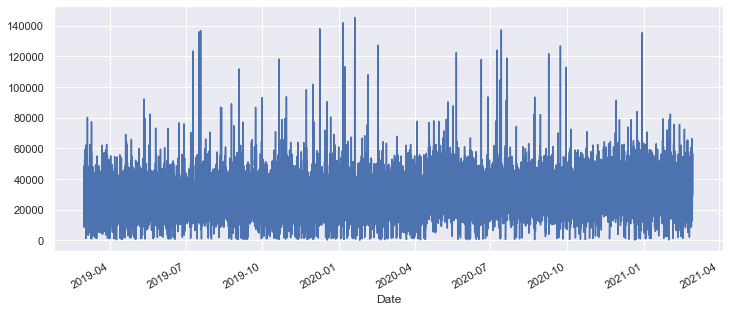

In [310]:
replace_start = pd.to_datetime("2019-03-15")
replace_end = pd.to_datetime("2019-04-15")

replace_with_start = pd.to_datetime("2019-02-15")
replace_with_end = pd.to_datetime("2019-04-15")

new_counted_df = counted_df.copy()
new_values = counted_df[(counted_df.index >= replace_start) & (counted_df.index < replace_end)]
new_values.index = new_values.index + datetime.timedelta(days=365)
new_counted_df = new_counted_df.reset_index()[["Date", "session_time"]]
new_values = new_values.reset_index()[["Date", "session_time"]]
converted = pd.merge(new_values, new_counted_df, on="Date", how="outer")
converted['session_time_x'] = converted['session_time_x'].fillna(converted['session_time_y'])

converted = converted.set_index("Date")
converted = converted.drop("session_time_y", axis=1)
y = converted["session_time_x"]
y.plot();
plt.show()

new_counted_df = mean_df.copy()
new_values = mean_df[(mean_df.index >= replace_start) & (mean_df.index < replace_end)]
new_values.index = new_values.index + datetime.timedelta(days=365)
new_counted_df = new_counted_df.reset_index()[["Date", "session_time"]]
new_values = new_values.reset_index()[["Date", "session_time"]]
converted = pd.merge(new_values, new_counted_df, on="Date", how="outer")
converted['session_time_x'] = converted['session_time_x'].fillna(converted['session_time_y'])

converted = converted.set_index("Date")
converted = converted.drop("session_time_y", axis=1)
y_mean = converted["session_time_x"]
y_mean.plot();


## Fit model

In [311]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

series = y * factor
# seasonal difference
X = series.values
days_in_year = 365 * 24
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(5,0,1))
model_fit = model.fit()



series2 = y_mean * factor
# seasonal difference
X = series.values
days_in_year = 365 * 24
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(5,0,1))
model_fit_mean = model.fit()





1.0021353579690373
Predict up until 2021-07-03 22:00:00
Number of EVs predicted for this sample  40
Number of new EVs charging between 14:00 and 16:00 1


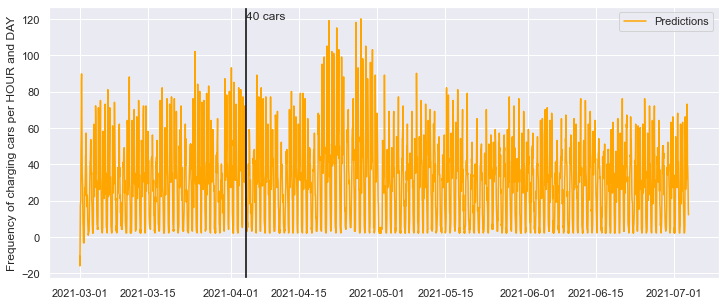

In [301]:

future_steps = 3000
last_date = y.index[-1]

X = y.values
# extend index
new_dates = []
for t in range(future_steps):
    new_date = last_date + datetime.timedelta(hours=t)
    new_dates.append(new_date)

forecast = model_fit.forecast(steps=future_steps)

# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    # print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

factor = len(X) / total_rows
print(factor)

results_df = pd.DataFrame(new_hist, index=new_index)
number_of_EVs = results_df[results_df.index == pd.to_datetime('2021-04-04 14:00:00')][0]
number_of_EVs_end = results_df[results_df.index == pd.to_datetime('2021-04-04 16:00:00')][0]

print("Number of EVs predicted for this sample ", round(number_of_EVs.values[0]))

difference = round(number_of_EVs.values[0] - number_of_EVs_end.values[0])
if difference < 0:
    print("Number of EVs discharged between 14:00 and 16:00", abs(round(difference)))
else:
    print("Number of new EVs charging between 14:00 and 16:00", round(difference))
    
new_index = list(series.index) + new_dates
print("Predict up until", new_index[-1])
new_hist = np.asarray(history) / np.asarray(factor)
section_index, section = new_index[-3000:], new_hist[-3000:]
df_copy = df.copy()[-3000:]
plt.plot(section_index, section, color='orange', label="Predictions")
plt.axvline(x=pd.to_datetime('2021-04-04'), linestyle="-", color="black")
plt.text(x=pd.to_datetime('2021-04-04'), y=np.max(section), s=str(int(number_of_EVs.values[0])) + " cars")
plt.ylabel("Frequency of charging cars per HOUR and DAY")
plt.legend()
plt.show()


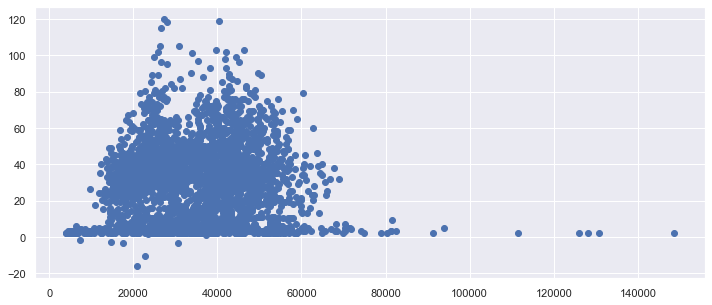

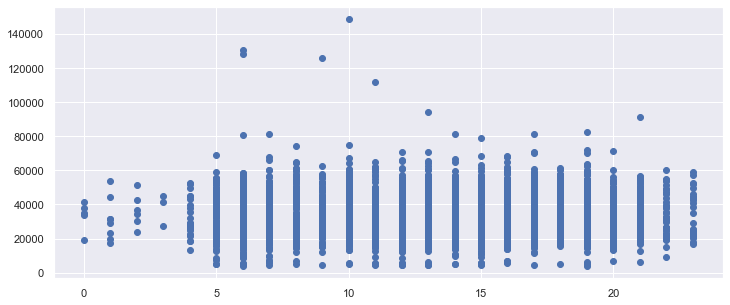

In [305]:
plt.scatter(remember, section);
plt.show()
plt.scatter(df_copy["Hour"], remember)

In [314]:
df[df["Date"] == pd.datetime("2021-02-02")]
# plt.show()
df_copy

,timestamp_start,timestamp_end,kwh_charged,session_time,week_day,session_time_hours,Date,Day,Hour
476925,2020-07-07 13:49:24,2020-07-08 04:51:49,7.350,54145,1,15.040278,2020-07-07 13:00:00,2020-07-07,13
476926,2020-07-21 07:15:45,2020-07-21 08:07:58,8.920,3133,1,0.870278,2020-07-21 07:00:00,2020-07-21,7
476927,2020-07-07 06:10:56,2020-07-07 11:45:18,35.436,20062,1,5.572778,2020-07-07 06:00:00,2020-07-07,6
476928,2020-07-03 15:59:59,2020-07-03 16:17:42,2.320,1063,4,0.295278,2020-07-03 15:00:00,2020-07-03,15
476929,2020-07-14 17:21:59,2020-07-14 20:33:15,9.499,11476,1,3.187778,2020-07-14 17:00:00,2020-07-14,17
...,...,...,...,...,...,...,...,...,...
479995,2020-07-09 07:24:37,2020-07-09 16:25:50,21.270,32473,3,9.020278,2020-07-09 07:00:00,2020-07-09,7
479996,2020-07-18 16:47:59,2020-07-20 03:33:55,1.350,125156,5,34.765556,2020-07-18 16:00:00,2020-07-18,16
479997,2020-07-31 12:21:58,2020-07-31 12:41:48,1.130,1190,4,0.330556,2020-07-31 12:00:00,2020-07-31,12
479998,2020-07-25 17:45:38,2020-07-25 19:29:42,2.960,6244,5,1.734444,2020-07-25 17:00:00,2020-07-25,17


In [253]:
import plotly.express as px

section_df = pd.DataFrame(section, index=section_index, columns=["Count"])
fig = px.bar(x=section_df.index, y=section_df.Count)
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.show()

section_df.to_pickle("results.p")

In [221]:
results_df = pd.DataFrame(new_hist, index=new_index)
number_of_EVs = results_df[results_df.index == pd.to_datetime('2021-04-04 14:00:00')][0]
number_of_EVs_end = results_df[results_df.index == pd.to_datetime('2021-04-04 16:00:00')][0]

print("Number of EVs predicted for this sample ", round(number_of_EVs.values[0]))

difference = round(number_of_EVs.values[0] - number_of_EVs_end.values[0])
if difference < 0:
    print("Number of EVs discharged between 14:00 and 16:00", abs(round(difference)))
else:
    print("Number of new EVs charging between 14:00 and 16:00", round(difference))

Number of EVs predicted for this sample  40
Number of new EVs charging between 14:00 and 16:00 1


In [73]:
means = []
def calc_over_runs(runs=20):
    for run in range(runs):
        print("run", run)
        model = ARIMA(differenced, order=(5,0,1))
        model_fit = model.fit()

        X = y.values
        forecast = model_fit.forecast(steps=future_steps)
        
        # invert the differenced forecast to something usable
        history = [x for x in X]
        day = 1
        for yhat in forecast:
            inverted = inverse_difference(history, yhat, days_in_year)
            # print('Day %d: %f' % (day, inverted))
            history.append(inverted)
            day += 1

        factor = len(X) / total_rows
        new_hist = np.asarray(history) / np.asarray(factor)
        means.append(new_hist)
    return np.mean(means, axis=0)
new_means = calc_over_runs(runs=3)

results_df = pd.DataFrame(new_means, index=new_index)
number_of_EVs = results_df[results_df.index == pd.to_datetime('2021-04-04 14:00:00')][0]
number_of_EVs_end = results_df[results_df.index == pd.to_datetime('2021-04-04 16:00:00')][0]
    
print("Number of EVs predicted for this sample ", round(number_of_EVs.values[0]))

difference = round(number_of_EVs.values[0] - number_of_EVs_end.values[0])
if difference < 0:
    print("Number of EVs discharged between 14:00 and 16:00", abs(round(difference)))
else:
    print("Number of new EVs charging between 14:00 and 16:00", round(difference))

run 0
run 1
run 2
Number of EVs predicted for this sample  2
Number of new EVs charging between 14:00 and 16:00 0


# Auto ARIMA

In [5]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(y)

(0.01, False)

From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

In [12]:
train, test = train_test_split(y, test_size=0.2)
# train = train.sort_index()
# test = test.sort_index()

In [ ]:
M = 3
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=M, max_d=M, max_q=M, start_P=0, 
                          D=1, start_Q=0, max_P=M, max_D=M,
                          max_Q=M, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = M )

In [ ]:
#Summary of the model
arima_model.summary()

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 20),index=test.index)
prediction.columns = ['predicted_sales']

plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'Left corner')
plt.show()

test['predicted_sales'] = prediction
r2_score(test['Champagne sales'], test['predicted_sales'])
